**@Auteur : Adem DEBBAHI Joris LARMAILLARD-NOIREN**

L'objectif de cet exercice est de mettre en place un modèle de régression linéaire afin de prédire le prix de logements.
Nous allons utiliser la base de données `BostonHousing` qui contient des informations que nous exploiterons.

# Importation des données


Tout d'abord, il faut importer le jeu de données en veillant bien à utiliser la bonne version de sklearn.

In [1]:
from sklearn.datasets import load_boston
import pandas as pd

boston = load_boston()
data = pd.DataFrame(boston.data, columns=boston.feature_names)
data['MEDV'] = boston.target

La dataset a bien été installé, et peut maintenant être exploité.

In [2]:
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


# Data Exploration

Avant de procéder à la régression, nous allons d'abord explorer les données, et voir comment elles se présentent.
Pour ce faire, nous utiliserons la librairie `ydata_profiling` pour obtenir un rapport sur le dataset.

In [3]:
### Importation du module
from ydata_profiling import ProfileReport

profile = ProfileReport(data, title='Boston Housing Data Report')
profile.to_file('boston_housing_report.html')

/opt/anaconda3/envs/linear_regression_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Export report to file: 100%|██████████| 1/1 [00:00<00:00, 280.42it/s]


Suite à notre analyse du fichier report, nous avons constaté les faits suivants :

Dans un premier nous analyserons la distribution de nos données à l'aide des histogrammes générés.

• Pour la variable `CRIM` : Distribution : crim montre une distribution généralement asymétrique à droite. La majorité des observations sont à faible taux de criminalité, mais il y a quelques quartiers avec des taux de criminalité  plus élevés, créant une queue à droite.

• Pour la variable `ZN`, nous voyons que les données ne sont pas équitablement distribuées, et qu'il y a une forte fréquence de "0", et de faibles fréquences pour le reste des données, signifiant ainsi qu'il y a très peu de logement ayant un terrain de plus de 25 000 pieds carrés.

• Pour la variable `INDUS`, elle présente une distribution qui légèrement asymétrique. La plupart des valeurs se regroupent autour de taux modérés d'occupation des sols commerciaux, mais des valeurs plus élevées existent, indiquant des zones plus industrialisées notamment entre 17 et 18 avec une forte occupation.

• Pour la variable `CHAS`, il y a une forte prépondérance de "0" dans le dataset par rapport à "1", montrant ainsi que peu de logements se trouvent à proximité de la rivière "Charles".

• Pour la variable `NOX`, sa distribution montre une concentration autour de niveaux moyens de pollution,mais il y a une coupure entre la polution entre 0.4 et 0.8 et la zone au dessus de 0.8.

• Pour la variable `RM`, les données sont centrées autour de "6", avec une répartition assez équitable. Majoritairement, les logements ont 6 chambres.

• Pour la variable `AGE`, elle a une distribution avec une concentration plus élevée autour de pourcentages élevés, reflétant la présence significative de maisons anciennes. Il existe aussi des zones avec une proportion plus faible de maisons anciennes.

• Pour la variable `DIS`, les données sont plus situées à gauche de l'histogramme, précisément autour de la valeur "2" signifiant que la plupart des logements sont situés à environ deux  kilomètres des centres d'affaires.

• Pour la variable `RAD`, certaines valeurs sont plus courantes, reflétant les différentes niveaux d'accessibilité aux routes principales dans les différentes.Il y a des zone avec beaucoup d'acces et d'autre avec  moin.

• Pour la variable `TAX`, les données ne sont pas équitablement réparties car nous observons une forte fréquence de valeurs autour des "660", et à gauche une distribution centrée autour de "300". Les logements les plus chers ont donc une taxe foncière d'envrion 660, tandis que les logements moins chers ont en moyenne une taxe foncière de 300. Cette différence fait que la moyenne générale est de "400".

• Pour la variable `PTRATIO`, elle tend à montrer une concentration autour de valeurs moyennes du nombre de pièces. Les maisons avec un très grand nombre de pièces sont moins fréquentes, ce qui peut induit une certaine asymétrie dans la distribution.

• Pour la variable `B`, les données sont centrées à droite autour de la valeur "400".

• Pour la variable `LSTAT`, elle est asymétrique à droite, avec des valeurs plus faibles prédominantes, ce qui indique que dans de nombreuses zones, le pourcentage de personnes avec un statut socio-économique inférieur est relativement bas.

• Pour la variable `MEDV`, les données sont réparties équitablement (centrées) autour de la moyenne "22", avec quelques aberrations autour de "50".

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.figure(figsize=(5, 5))

data['DIS^2'] = data['DIS'].map(lambda x: x **2 )

sns.scatterplot(x=data['DIS^2'], y=data['MEDV'])

plt.show()

/var/folders/cm/g3vjzls55yxbg6g8n92xg7tr0000gp/T/ipykernel_15276/3405345533.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.show()


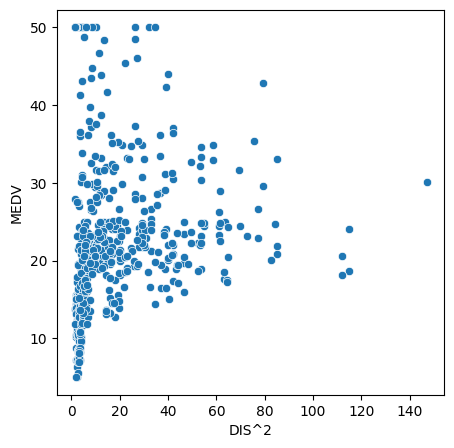

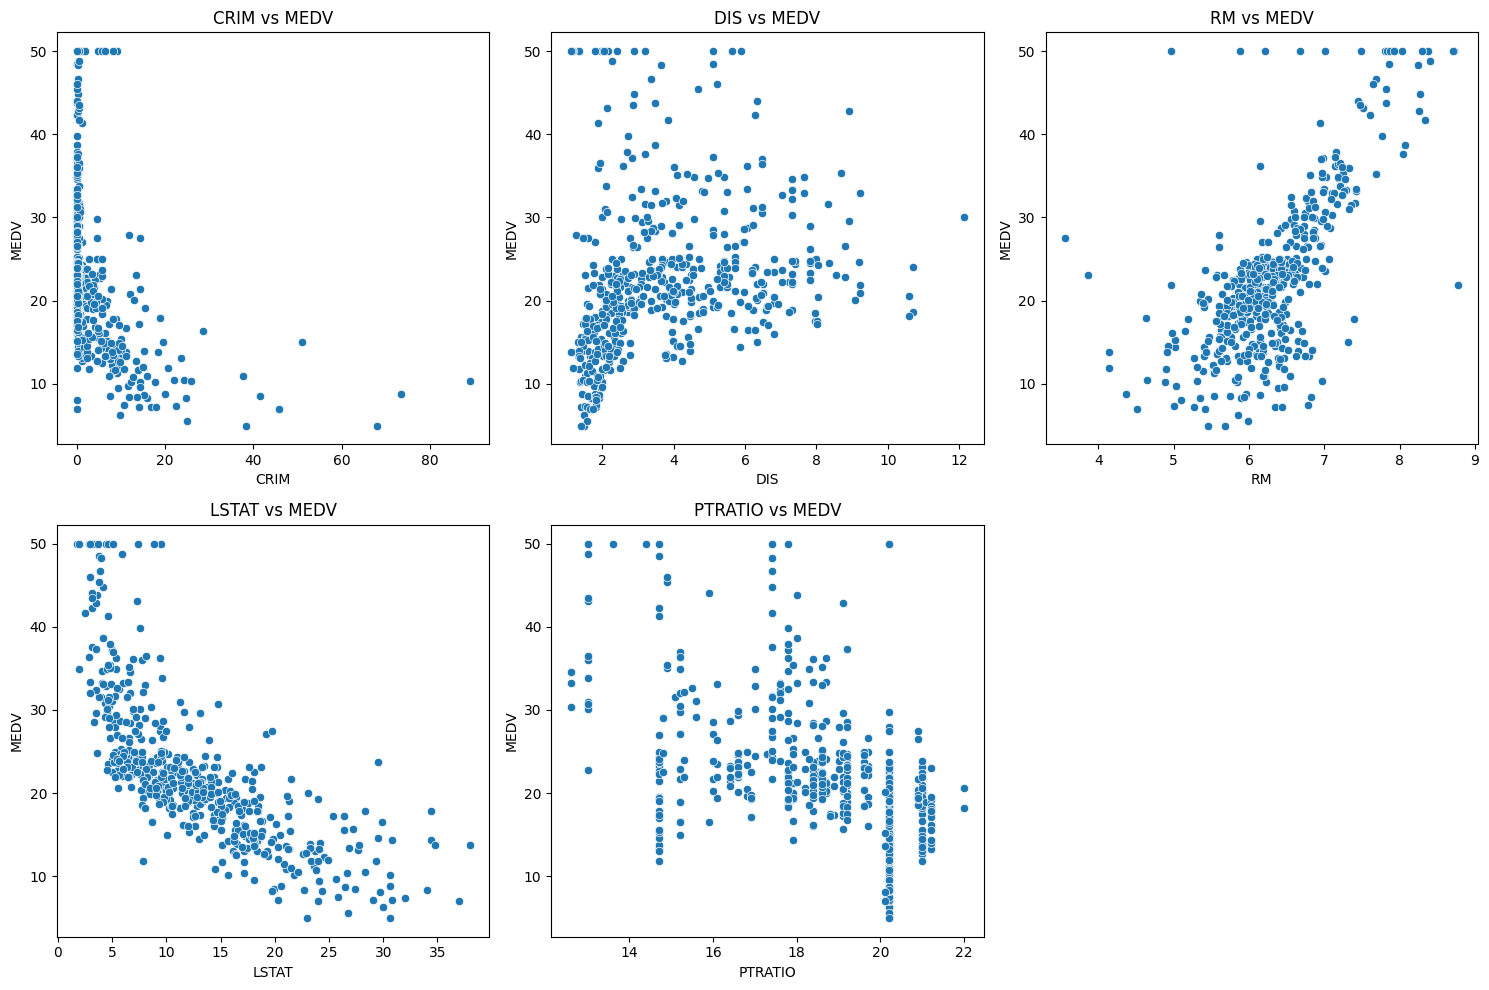

In [5]:
### Affichage des interractions entre la sélection de nos variables pertinentes et la variable cible

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline

### Variables pertinentes
variables_pertinentes = ['CRIM', 'DIS', 'RM', 'LSTAT', 'PTRATIO'];

### Création des scatter plots
plt.figure(figsize=(15, 10))

for i, var in enumerate(variables_pertinentes):
    plt.subplot(2, 3, i + 1)
    sns.scatterplot(x=data[var], y=data['MEDV'])
    plt.title(f'{var} vs MEDV')

plt.tight_layout()
plt.show()

             CRIM        ZN     INDUS      CHAS       NOX        RM       AGE  \
CRIM     1.000000 -0.200469  0.406583 -0.055892  0.420972 -0.219247  0.352734   
ZN      -0.200469  1.000000 -0.533828 -0.042697 -0.516604  0.311991 -0.569537   
INDUS    0.406583 -0.533828  1.000000  0.062938  0.763651 -0.391676  0.644779   
CHAS    -0.055892 -0.042697  0.062938  1.000000  0.091203  0.091251  0.086518   
NOX      0.420972 -0.516604  0.763651  0.091203  1.000000 -0.302188  0.731470   
RM      -0.219247  0.311991 -0.391676  0.091251 -0.302188  1.000000 -0.240265   
AGE      0.352734 -0.569537  0.644779  0.086518  0.731470 -0.240265  1.000000   
DIS     -0.379670  0.664408 -0.708027 -0.099176 -0.769230  0.205246 -0.747881   
RAD      0.625505 -0.311948  0.595129 -0.007368  0.611441 -0.209847  0.456022   
TAX      0.582764 -0.314563  0.720760 -0.035587  0.668023 -0.292048  0.506456   
PTRATIO  0.289946 -0.391679  0.383248 -0.121515  0.188933 -0.355501  0.261515   
B       -0.385064  0.175520 

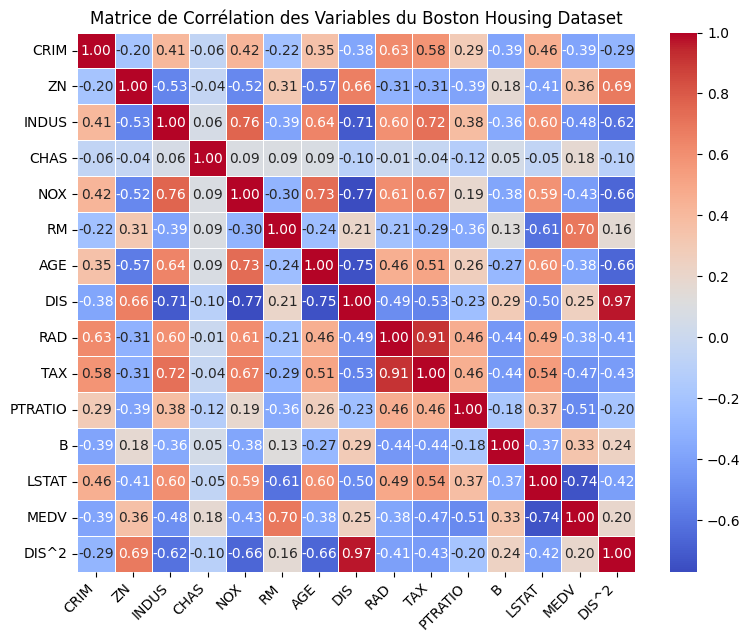

In [6]:
### Calculer la matrice de corrélation
corr_matrix = data.corr();

### Afficher la matrice de corrélation
print(corr_matrix)
# Configurer la taille de la figure
plt.figure(figsize=(9, 7))


### Créer une heatmap de la matrice de corrélation
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5,xticklabels=corr_matrix.columns, 
            # Utiliser les noms des colonnes comme étiquettes
            yticklabels=corr_matrix.columns)
plt.xticks(rotation=45, ha='right')  # Rotation des étiquettes x
plt.yticks(rotation=0) 

### Afficher la heatmap
plt.title("Matrice de Corrélation des Variables du Boston Housing Dataset")
plt.show()


Comme nous pouvons le constater, par exemple pour les crimes, moins il y a de crimes `CRIM` dans la ville, plus le nombre d'occupants des maisons `MEDV` est élevé, et inversement.
Également, plus le taux d'habitant ayant un status bas est élevé `LSTAT`, moins le nombre d'habitant est élevé. Nous observons aussi une forte corrélation entre le nombre de chambre par habitation `RM` et le prix des habitation `MEDV` : plus il y a de chambres, plus le prix augmente (ce qui paraît logique).
Par ailleurs, nous pouvons observer qu'il n'y a pas de corrélation entre le prix `MEDV` et le ratio prof-élève `PTRATIO`.



Toutefois, nous voyons `ProfileReport` fournit une matrice de corrélation avec des valeurs différentes de celles fournies par `seaborn`. Nous avons conclu que cela était principalement dû au fait que les deux programmes n'utilisent pas le même type de corrélation. 

**Sélection des variables pertinentes**

Les trois features que nous garderons sont `LSTAT`, `CRIM` et `RM` car elles fournissent un taux de corrélation positif/négatif avec notre variable cible. Premièrement, nous avons choisi `CRIM` car plus il y a de criminalité aux abords d'une habitation moins elle attirera les potentiels acheteurs, et donc son prix dimunera : nous observons juste une logique de causalité. Ensuite, nous avons choisi `RM` car plus il y a de pièce dans le logement, plus le prix du logement augmentera en conséquence. Et pour finir, nous avons choisi également la variable `LSTAT` car pour les personnes ayant un rang social moins élevé, il sera difficile pour elle de se payer un logement couteux.

# Régression linéaire

Dans cette partie, il s'agira de mettre en place un modèle de régression dans le but de prédire le prix du logement.

**Régression linéaire simple**

Nous ferons dans un premier un modèle à partir d'une régression linéaire simple en utilisant nos données de façon brute.

In [7]:
### Importation des modules

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [8]:
X = data[['RM']]
y = data['MEDV']

### Split des données en sous-ensembles d'entraînements et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Création du modèle et entraînement du modèle
model = LinearRegression()
model.fit(X_train, y_train)

### Prédictions
y_pred = model.predict(X_test)

### Évaluation du modèle
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error : {mse}")
print(f"R2 score : {r2}")

Mean Squared Error : 46.14477534731728
R2 score : 0.3707569232254776


Suite à notre premier test, nous voyons que l'erreur quadratique moyenne est d'environ 46, et que le score `R²` est de 0.37, signifiant ainsi que les prédictions du modèles ne sont pas bonnes, et qu'il explique mal la variabilité des données à cause du bruit autour des données.
Et donc, nous pensons, que dans ce modèle simple, la variable `RM` n'est pas celle qui pourrait nous expliquer le mieux le prix des logements, et donc faire de bonnes prédictions.

Maintenant, nous allons testé la variable `LSTAT`.

In [9]:
X = data[['LSTAT']]
y = data['MEDV']

### Split des données en sous-ensembles d'entraînements et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Création du modèle et entraînement du modèle
model = LinearRegression()
model.fit(X_train, y_train)

### Prédictions
y_pred = model.predict(X_test)

### Évaluation du modèle
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error : {mse}")
print(f"R2 score : {r2}")

Mean Squared Error : 33.51954917268488
R2 score : 0.5429180422970386


Tout, d'abord, nous voyons une nette amélioration dans les scores : le modèle comprend mieux la variabilité des données, et ses prédictions se sont améliorées.
Nous pensons que nous améliorer ce modèle en prenant en compte le logarithme de nos variables `LSTAT` et `MEDV`, car en observant les données sur le graphes produit précédemment, il semble qu'il y ait une tendance logarithmique. D'abbord, faisons quelques aperçus de nos données transformées.

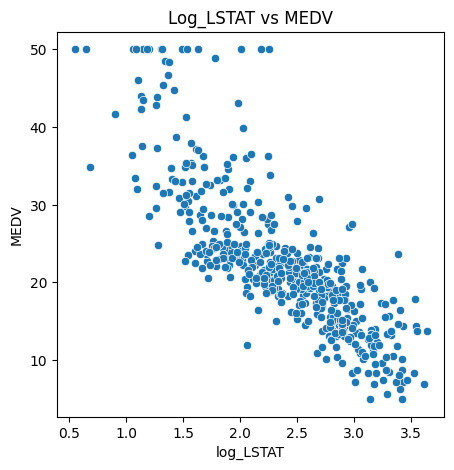

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.figure(figsize=(5, 5))

data['log_LSTAT'] = data['LSTAT'].map(lambda x: np.log(x))

sns.scatterplot(x=data['log_LSTAT'], y=data['MEDV'])
plt.title('Log_LSTAT vs MEDV')

plt.show()

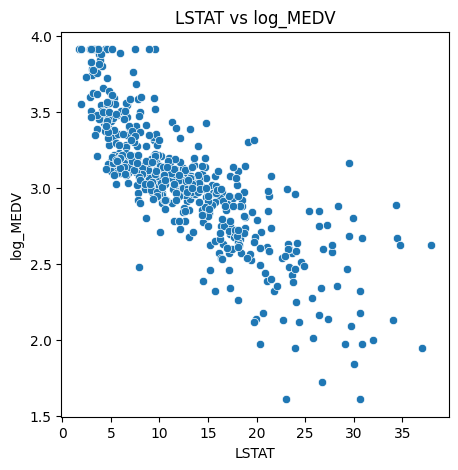

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.figure(figsize=(5, 5))

data['log_MEDV'] = data['MEDV'].map(lambda x: np.log(x))

sns.scatterplot(x=data['LSTAT'], y=data['log_MEDV'])
plt.title('LSTAT vs log_MEDV')

plt.show()

Comme nous pouvons le voir, en utilisant le `log_LSTAT`, ou le `log_MEDV`, la tendance devient plus un peu plus linéaire. Donc en utilisant l'une de ces deux nouvelles variables, nous pensons que cela améliorera les performances du modèles.

In [12]:
X = data[['log_LSTAT']]
y = data['MEDV']

### Split des données en sous-ensembles d'entraînements et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Création du modèle et entraînement du modèle
model = LinearRegression()
model.fit(X_train, y_train)

### Prédictions
y_pred = model.predict(X_test)

### Évaluation du modèle
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error : {mse}")
print(f"R2 score : {r2}")

Mean Squared Error : 24.323081885886605
R2 score : 0.6683236451512222


En utilisant la nouvelle variable `log_LSTAT`, nous obtenons une `MSE = 24.32` et `R² = 0.67` suggèrent que votre modèle est modérément performant. Il explique une partie significative des données, mais il laisse encore des erreurs non négligeables.

Enfin, passons à notre dernière variable selectionnée, `CRIM`, et voyons comment se comporte le modèle.

In [13]:
X = data[['CRIM']]
y = data['MEDV']

### Split des données en sous-ensembles d'entraînements et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Création du modèle et entraînement du modèle
model = LinearRegression()
model.fit(X_train, y_train)

### Prédictions
y_pred = model.predict(X_test)

### Évaluation du modèle
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error : {mse}")
print(f"R2 score : {r2}")

Mean Squared Error : 61.694137455660794
R2 score : 0.15872146782902863


Comme nous pouvons le voir, en utilisant les variables `CRIM` et `MEDV`, cela montre que le modèle n'est pas du tout performant. Nous pouvons constater une augmentation de l'erreur quadratrique moyenne, passant de 24.32 à 61.69. Nous pouvons dire que le modèle fait des erreurs dans ses prédictions, et qu'elles sont éloignées des valeurs réelles observées. De plus, nous avons également une nette diminution du score R², passant de 0.66 à 0.16. Donc, le modèle n'arrive pas à comprendre les liens entre les différentes features.

**Régression multilinéaire**

Maintenant, nous allons mettre en place un modèle de régression multilinéaire.

In [14]:
X = data.drop('MEDV', axis=1)
y = data['MEDV']

### Sépération de l'ensemble des données en sous-ensemble d'entraînement, et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Création du modèle et entraînement
model = LinearRegression()
model.fit(X_train, y_train)

### Prédictions
y_pred = model.predict(X_test)

### Évaluation du modèle
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R2: {r2}')

Mean Squared Error: 4.115027710507822
R2: 0.9438863299673015


Ces nouveaux résultats nous permettent de voir que, non seulement les prédictions du modèles sont précises par rapport aux données réelles, et donc son erreur de prédiction est faible, mais il arrive aussi à comprendre le lien entre les différentes caractéristiques.